In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.applications as apps
from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

seed(42)
set_seed(42)

2023-06-23 18:09:35.288816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-23 18:09:35.390363: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2023-06-23 18:09:35.390378: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-23 18:09:35.925063: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object

# Estratégia 1: Treino com o dataset 1 e teste com o nosso dataset:

## Extração do Dataset para Grayscale

In [2]:
def GrayScale(image):
    return cv.cvtColor(cv.cvtColor(image, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB)

In [3]:
from sklearn.model_selection import train_test_split
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
# Extrair imagens da pasta

# Para treino
X_image_train = []
y_train = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/train/'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/Dataset/train/{letra}'):
        X_image_train.append(GrayScale(image))
        y_train.append(cont)
    cont += 1

# Para teste e validação
X_extra = []
y_extra = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/{letra}'):
        X_extra.append(GrayScale(image))
        y_extra.append(cont)
    cont += 1

In [5]:
cont = 0
for image in np.asarray(X_image_train):
    X_image_train[cont] = cv.resize(image, [64, 64])
    cont += 1 
    
cont = 0
for image in np.asarray(X_extra):
    X_extra[cont] = cv.resize(image, [64, 64])
    cont += 1 

X_image_train = np.asarray(X_image_train)
y_train = np.asarray(y_train)
X_extra = np.asarray(X_extra)
y_extra = np.asarray(y_extra)

In [6]:
print(f"train data shape: {X_image_train.shape}")
print(f"train label shape: {y_train.shape}")
print(f"extra data shape: {X_extra.shape}")
print(f"extra label shape: {y_extra.shape}")

train data shape: (33064, 64, 64, 3)
train label shape: (33064,)
extra data shape: (1505, 64, 64, 3)
extra label shape: (1505,)


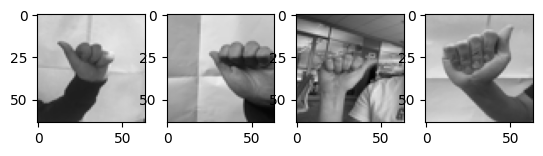

In [7]:
# Visualizar imagens
fig, axes = plt.subplots(1, 4)
axes[0].imshow(X_extra[0])
axes[1].imshow(X_extra[1])
axes[2].imshow(X_extra[2])
axes[3].imshow(X_extra[3])
plt.show()

In [8]:
# Dados de Treino, Validação e Teste

idx = np.random.permutation(len(X_image_train))
X_image_train,y_train = X_image_train[idx], y_train[idx] # Shuffle em treino
X_image_test, X_image_val, y_test, y_val = train_test_split(X_extra, y_extra, test_size=0.4)

In [9]:
# Binarizar rotolus

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [10]:
print(f"original: {lb.inverse_transform(y_train[0:5])}\n")
print(f"binarizado:\n{y_train[0:5]}")

original: [13 13 19  9  3]

binarizado:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Aplicando FineTunning com EfficientNetB3

In [11]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

modelBase = apps.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
modelBase = Model(inputs=modelBase.input, outputs=modelBase.get_layer(index=-1).output)
modelBase.trainable = False

2023-06-23 18:10:13.773222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/emanueloliveira/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-06-23 18:10:13.773240: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-23 18:10:13.773255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emanueloliveira-CI581128TBW10): /proc/driver/nvidia/version does not exist
2023-06-23 18:10:13.773389: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations,

In [12]:
print("Model output", modelBase.output.shape)

Model output (None, 2, 2, 1536)


In [13]:
preds = modelBase.predict(np.array(X_image_train)[0:5])

1/1 [==============================] - 2s 2s/step


In [14]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1536)


In [15]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [16]:
# Extração de features
print("Feature extraction ...")
predictionTrain = np.array(modelBase.predict(X_image_train))
featuresTrain = np.reshape(predictionTrain, (predictionTrain.shape[0], Predshape))
predictionVal = np.array(modelBase.predict(X_image_val))
featuresVal = np.reshape(predictionVal, (predictionVal.shape[0], Predshape))
predictionTest = np.array(modelBase.predict(X_image_test))
featuresTest = np.reshape(predictionTest, (predictionTest.shape[0], Predshape))

print('\tFeatures data shape: ', featuresTrain.shape)

Feature extraction ...
29/29 [==============================] - 3s 107ms/step
	Features data shape:  (33064, 6144)


In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(featuresTrain)
X_val = pca.transform(featuresVal)
X_test = pca.transform(featuresTest)

print('X_train shape: ', X_train.shape)

X_train shape:  (33064, 184)


## Rede Classificadora

In [18]:
# Creating the Sequential Model
model = keras.Sequential([
    # Fully-connected layer
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
2067/2067 [==============================] - 2s 1ms/step - loss: 0.3980 - categorical_accuracy: 0.9160 - val_loss: 3.7190 - val_categorical_accuracy: 0.1561
Epoch 2/100
2067/2067 [==============================] - 2s 935us/step - loss: 0.0268 - categorical_accuracy: 0.9975 - val_loss: 4.0183 - val_categorical_accuracy: 0.1512
Epoch 3/100
2067/2067 [==============================] - 2s 944us/step - loss: 0.0118 - categorical_accuracy: 0.9989 - val_loss: 4.3801 - val_categorical_accuracy: 0.1595
Epoch 4/100
2067/2067 [==============================] - 2s 998us/step - loss: 0.0064 - categorical_accuracy: 0.9995 - val_loss: 4.8063 - val_categorical_accuracy: 0.1645
Epoch 5/100
2067/2067 [==============================] - 2s 917us/step - loss: 0.0039 - categorical_accuracy: 0.9997 - val_loss: 5.2093 - val_categorical_accuracy: 0.1694
Epoch 6/100
2067/2067 [==============================] - 2s 954us/step - loss: 0.0024 - categorical_accuracy: 0.9998 - val_loss: 5.6360 - val_categ

Best Validation Loss: 3.7190
Best Validation Accuracy: 17.1096%


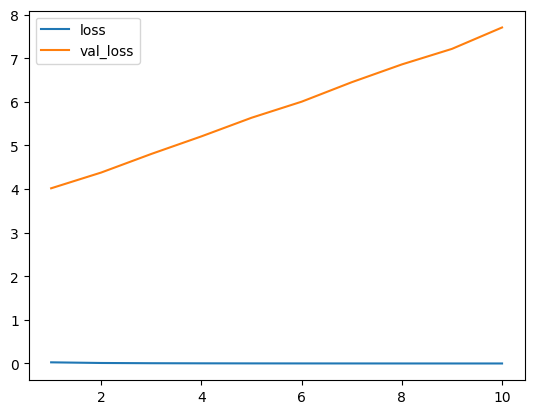

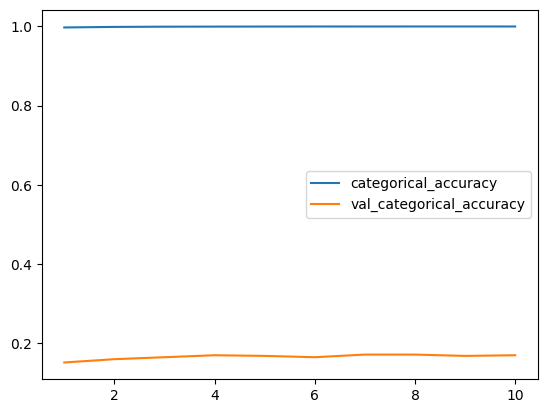

In [20]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [21]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_test, y_test)[1]*100, 4)}%")

29/29 [==============================] - 0s 2ms/step - loss: 3.6633 - categorical_accuracy: 0.1916
Acurácia em dados de teste: 19.1584%


# Resultado Estratégia 1:
    Acurácia em dados de teste: 19.1584%
    Best Validation Loss: 3.7190
    Best Validation Accuracy: 17.1096%

# Estratégia 2: Treino e teste com o nosso dataset com fine tunning utilizando a EfficientNetB3

## Extração do Dataset em GrayScale

In [82]:
def GrayScale(image):
    return cv.cvtColor(cv.cvtColor(image, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB)

In [83]:
from sklearn.model_selection import train_test_split
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [84]:
# Extrair imagens da pasta

X_data = []
y_data = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/{letra}'):
        X_data.append(GrayScale(image))
        y_data.append(cont)
    cont += 1

In [85]:
cont = 0
for image in np.asarray(X_data):
    X_data[cont] = cv.resize(image, [64, 64])
    cont += 1 

X_data = np.asarray(X_data)
y_data = np.asarray(y_data)

In [86]:
X_data = np.array(X_data)
y_data = np.array(y_data)

print(X_data.shape)
print(y_data.shape)

(1505, 64, 64, 3)
(1505,)


In [87]:
# Dados de Treino, Validação e Teste

X_image_train, X_image_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1)
X_image_train, X_image_val, y_train, y_val = train_test_split(X_image_train, y_train, test_size=0.1)

In [88]:
# Binarizar rotolus

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [89]:
print(f"original: {lb.inverse_transform(y_train[0:5])}\n")
print(f"binarizado:\n{y_train[0:5]}")

original: [12  2 15  9 18]

binarizado:
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


## Modelo Utilizado para FineTunning (EfficientNetB3 completa)

In [217]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

modelBase = apps.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
modelBase = Model(inputs=modelBase.input, outputs=modelBase.get_layer(index=-1).output)
modelBase.trainable = False

In [218]:
print("Model output", modelBase.output.shape)

Model output (None, 2, 2, 1536)


In [219]:
print(type(X_data))

<class 'numpy.ndarray'>


In [220]:
preds = modelBase.predict(np.array(X_data)[0:5])

1/1 [==============================] - 1s 1s/step


In [221]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1536)


In [222]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [223]:
# Extração de features
print("Feature extraction ...")
predictionTrain = np.array(modelBase.predict(X_image_train))
featuresTrain = np.reshape(predictionTrain, (predictionTrain.shape[0], Predshape))
predictionVal = np.array(modelBase.predict(X_image_val))
featuresVal = np.reshape(predictionVal, (predictionVal.shape[0], Predshape))
predictionTest = np.array(modelBase.predict(X_image_test))
featuresTest = np.reshape(predictionTest, (predictionTest.shape[0], Predshape))

print('\tFeatures data shape: ', featuresTrain.shape)

Feature extraction ...
5/5 [==============================] - 0s 83ms/step
	Features data shape:  (1218, 6144)


In [224]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(featuresTrain)
X_val = pca.transform(featuresVal)
X_test = pca.transform(featuresTest)

print('X_train shape: ', X_train.shape)

X_train shape:  (1218, 360)


## Rede Classificadora

In [241]:
# Creating the Sequential Model
model = keras.Sequential([
    # Fully-connected layer
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [242]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
77/77 [==============================] - 0s 2ms/step - loss: 3.5708 - categorical_accuracy: 0.0903 - val_loss: 3.1151 - val_categorical_accuracy: 0.1324
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 2.7562 - categorical_accuracy: 0.2085 - val_loss: 2.6235 - val_categorical_accuracy: 0.2426
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 2.1655 - categorical_accuracy: 0.3834 - val_loss: 2.2812 - val_categorical_accuracy: 0.3676
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 1.7355 - categorical_accuracy: 0.5468 - val_loss: 2.0512 - val_categorical_accuracy: 0.4559
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 1.4266 - categorical_accuracy: 0.6683 - val_loss: 1.8773 - val_categorical_accuracy: 0.4779
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 1.1989 - categorical_accuracy: 0.7512 - val_loss: 1.7589 - val_categorical_accuracy: 0.5000
Epoch 7/10

Best Validation Loss: 1.3110
Best Validation Accuracy: 67.6471%


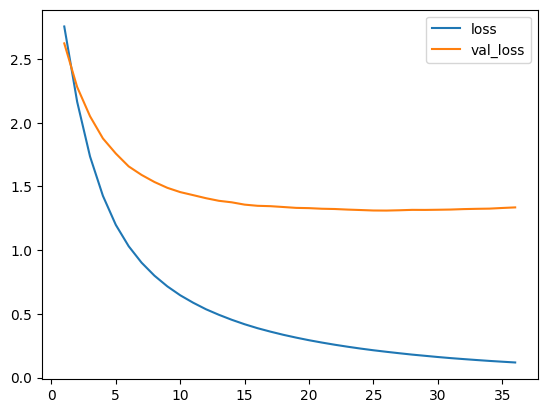

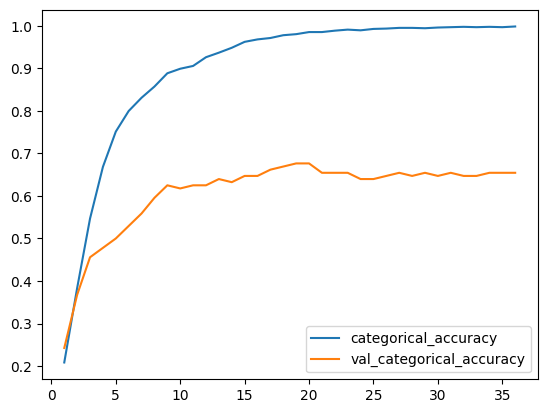

In [243]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [244]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 1ms/step - loss: 1.3668 - categorical_accuracy: 0.6159
Acurácia em dados de teste: 61.5894%


# Resultado Estratégia 2:
    Acurácia em dados de teste: 61.5894%
    Best Validation Loss: 1.3110
    Best Validation Accuracy: 67.6471%

# Estratégia 3: Treino e teste com o nosso dataset em uma CNN rasa

In [257]:
# Creating the Sequential Model
model = keras.Sequential([
    
    # Fully-connected layer
    layers.Conv2D(64, kernel_size=(3,3), strides=(2, 2), padding='same', activation="relu", input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.Conv2D(64, kernel_size=(3,3), padding='same', activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 conv2d_101 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_102 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_103 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 conv2d_104 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                     

In [258]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_image_train, y_train,
    validation_data=(X_image_val, y_val),
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
39/39 [==============================] - 7s 171ms/step - loss: 4.7627 - categorical_accuracy: 0.0575 - val_loss: 2.9710 - val_categorical_accuracy: 0.0662
Epoch 2/100
39/39 [==============================] - 7s 173ms/step - loss: 2.8146 - categorical_accuracy: 0.1568 - val_loss: 3.0500 - val_categorical_accuracy: 0.1029
Epoch 3/100
39/39 [==============================] - 6s 165ms/step - loss: 2.5176 - categorical_accuracy: 0.2627 - val_loss: 2.5224 - val_categorical_accuracy: 0.3162
Epoch 4/100
39/39 [==============================] - 6s 163ms/step - loss: 2.0460 - categorical_accuracy: 0.4048 - val_loss: 2.1740 - val_categorical_accuracy: 0.3971
Epoch 5/100
39/39 [==============================] - 7s 168ms/step - loss: 1.5329 - categorical_accuracy: 0.5616 - val_loss: 2.0683 - val_categorical_accuracy: 0.5147
Epoch 6/100
39/39 [==============================] - 7s 170ms/step - loss: 1.2546 - categorical_accuracy: 0.6453 - val_loss: 1.8967 - val_categorical_accuracy: 0.544

Best Validation Loss: 1.8967
Best Validation Accuracy: 59.5588%


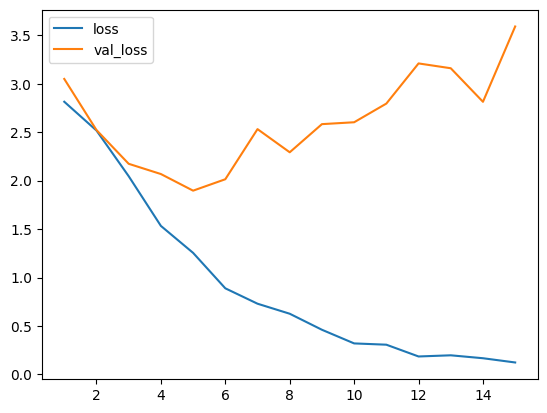

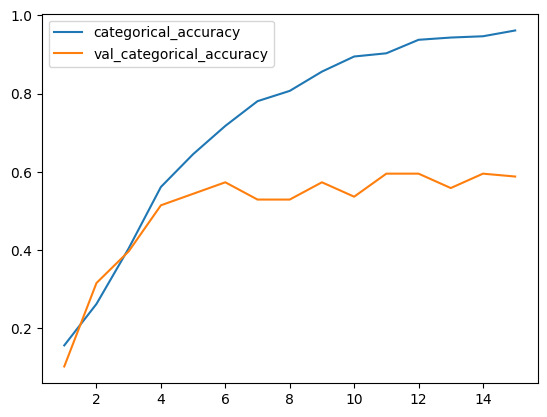

In [259]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [260]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_image_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 33ms/step - loss: 1.7889 - categorical_accuracy: 0.5629
Acurácia em dados de teste: 56.2914%


# Resultado Estratégia 3:
    Acurácia em dados de teste: 56.2914%
    Best Validation Loss: 1.8967
    Best Validation Accuracy: 59.5588%

# Estratégia 4: Treinamento e teste utilizando uma adaptação da EfficientNetB3 com o nosso dataset

## Extração do Dataset em GrayScale

In [82]:
def GrayScale(image):
    return cv.cvtColor(cv.cvtColor(image, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB)

In [83]:
from sklearn.model_selection import train_test_split
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [84]:
# Extrair imagens da pasta

X_data = []
y_data = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/{letra}'):
        X_data.append(GrayScale(image))
        y_data.append(cont)
    cont += 1

In [85]:
cont = 0
for image in np.asarray(X_data):
    X_data[cont] = cv.resize(image, [64, 64])
    cont += 1 

X_data = np.asarray(X_data)
y_data = np.asarray(y_data)

In [86]:
X_data = np.array(X_data)
y_data = np.array(y_data)

print(X_data.shape)
print(y_data.shape)

(1505, 64, 64, 3)
(1505,)


In [87]:
# Dados de Treino, Validação e Teste

X_image_train, X_image_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1)
X_image_train, X_image_val, y_train, y_val = train_test_split(X_image_train, y_train, test_size=0.1)

In [88]:
# Binarizar rotolus

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [89]:
print(f"original: {lb.inverse_transform(y_train[0:5])}\n")
print(f"binarizado:\n{y_train[0:5]}")

original: [12  2 15  9 18]

binarizado:
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


## Modelo Utilizado para FineTunning (1/3 inicial da rede EfficientNetB3)

In [90]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

modelBase = apps.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
modelBase = Model(inputs=modelBase.input, outputs=modelBase.get_layer(index=-140).output)
modelBase.trainable = False

In [91]:
print("Model output", modelBase.output.shape)

Model output (None, 4, 4, 816)


In [92]:
print(type(X_data))

<class 'numpy.ndarray'>


In [93]:
preds = modelBase.predict(np.array(X_data)[0:5])

1/1 [==============================] - 1s 943ms/step


In [94]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (4, 4, 816)


In [95]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [96]:
# Extração de features
print("Feature extraction ...")
predictionTrain = np.array(modelBase.predict(X_image_train))
featuresTrain = np.reshape(predictionTrain, (predictionTrain.shape[0], Predshape))
predictionVal = np.array(modelBase.predict(X_image_val))
featuresVal = np.reshape(predictionVal, (predictionVal.shape[0], Predshape))
predictionTest = np.array(modelBase.predict(X_image_test))
featuresTest = np.reshape(predictionTest, (predictionTest.shape[0], Predshape))

print('\tFeatures data shape: ', featuresTrain.shape)

Feature extraction ...
5/5 [==============================] - 0s 79ms/step
	Features data shape:  (1218, 13056)


In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(featuresTrain)
X_val = pca.transform(featuresVal)
X_test = pca.transform(featuresTest)

print('X_train shape: ', X_train.shape)

X_train shape:  (1218, 626)


## Rede Classificadora

In [98]:
# Creating the Sequential Model
model = keras.Sequential([
    # Fully-connected layer
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [99]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
77/77 [==============================] - 0s 3ms/step - loss: 3.3287 - categorical_accuracy: 0.1010 - val_loss: 2.7872 - val_categorical_accuracy: 0.1985
Epoch 2/100
77/77 [==============================] - 0s 1ms/step - loss: 2.2905 - categorical_accuracy: 0.3514 - val_loss: 2.2413 - val_categorical_accuracy: 0.3824
Epoch 3/100
77/77 [==============================] - 0s 1ms/step - loss: 1.5634 - categorical_accuracy: 0.6371 - val_loss: 1.8504 - val_categorical_accuracy: 0.5000
Epoch 4/100
77/77 [==============================] - 0s 1ms/step - loss: 1.0787 - categorical_accuracy: 0.8186 - val_loss: 1.5924 - val_categorical_accuracy: 0.5662
Epoch 5/100
77/77 [==============================] - 0s 1ms/step - loss: 0.7687 - categorical_accuracy: 0.9130 - val_loss: 1.4138 - val_categorical_accuracy: 0.6250
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.5685 - categorical_accuracy: 0.9573 - val_loss: 1.2861 - val_categorical_accuracy: 0.6471
Epoch 7/10

Best Validation Loss: 0.7545
Best Validation Accuracy: 75.0000%


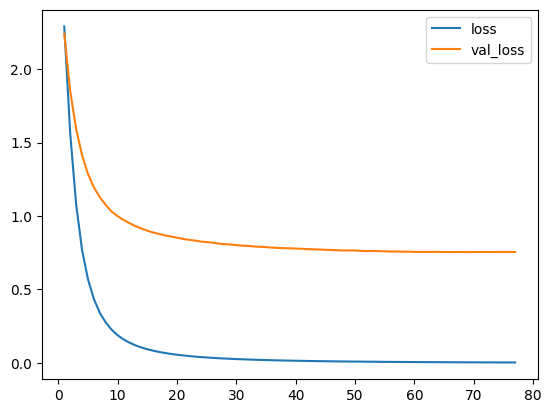

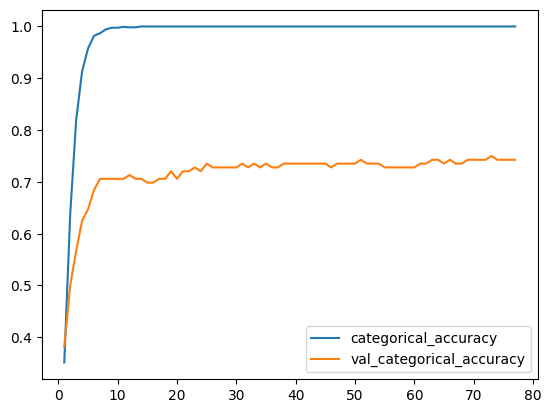

In [100]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [101]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_test, y_test)[1]*100, 4)}%")

5/5 [==============================] - 0s 1ms/step - loss: 0.7562 - categorical_accuracy: 0.8212
Acurácia em dados de teste: 82.1192%


# Resultado Estratégia 4:
    Acurácia em dados de teste: 82.1192%
    Best Validation Loss: 0.7545
    Best Validation Accuracy: 75.0000%

# Estratégia Extra: Treino com dataset Unificado e Teste com nosso dataset

## Extração do Dataset para Grayscale

In [41]:
def GrayScale(image):
    return cv.cvtColor(cv.cvtColor(image, cv.COLOR_RGB2GRAY), cv.COLOR_GRAY2RGB)

In [42]:
from sklearn.model_selection import train_test_split
import cv2 as cv
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [43]:
# Extrair imagens da pasta

# Para treino
X_image_train = []
y_train = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/DatasetUnificado/'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/DatasetUnificado/{letra}'):
        X_image_train.append(GrayScale(image))
        y_train.append(cont)
    cont += 1

# Para teste e validação
X_extra = []
y_extra = []
cont = 0
for letra in os.listdir('/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/'):
    for image in load_images_from_folder(f'/media/emanueloliveira/Dados/SCC0910ComputerVision/NossoDatasetAug/{letra}'):
        X_extra.append(GrayScale(image))
        y_extra.append(cont)
    cont += 1

In [44]:
cont = 0
for image in np.asarray(X_image_train):
    X_image_train[cont] = cv.resize(image, [64, 64])
    cont += 1 
    
cont = 0
for image in np.asarray(X_extra):
    X_extra[cont] = cv.resize(image, [64, 64])
    cont += 1 

X_image_train = np.asarray(X_image_train)
y_train = np.asarray(y_train)
X_extra = np.asarray(X_extra)
y_extra = np.asarray(y_extra)

/tmp/ipykernel_48772/917699711.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for image in np.asarray(X_image_train):


In [45]:
print(f"train data shape: {X_image_train.shape}")
print(f"train label shape: {y_train.shape}")
print(f"extra data shape: {X_extra.shape}")
print(f"extra label shape: {y_extra.shape}")

train data shape: (37472, 64, 64, 3)
train label shape: (37472,)
extra data shape: (1505, 64, 64, 3)
extra label shape: (1505,)


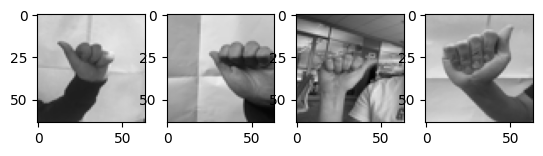

In [46]:
# Visualizar imagens
fig, axes = plt.subplots(1, 4)
axes[0].imshow(X_extra[0])
axes[1].imshow(X_extra[1])
axes[2].imshow(X_extra[2])
axes[3].imshow(X_extra[3])
plt.show()

In [47]:
# Dados de Treino, Validação e Teste

idx = np.random.permutation(len(X_image_train))
X_image_train,y_train = X_image_train[idx], y_train[idx] # Shuffle em treino
X_image_test, X_image_val, y_test, y_val = train_test_split(X_extra, y_extra, test_size=0.4)

In [48]:
# Binarizar rotolus

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [49]:
print(f"original: {lb.inverse_transform(y_train[0:5])}\n")
print(f"binarizado:\n{y_train[0:5]}")

original: [ 9  8 10  1 18]

binarizado:
[[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


## Aplicando FineTunning com EfficientNetB3

In [50]:
import tensorflow.keras.applications as apps
from tensorflow import keras
from tensorflow.keras import layers

modelBase = apps.EfficientNetB3(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
modelBase = Model(inputs=modelBase.input, outputs=modelBase.get_layer(index=-1).output)
modelBase.trainable = False

In [51]:
print("Model output", modelBase.output.shape)

Model output (None, 2, 2, 1536)


In [52]:
preds = modelBase.predict(np.array(X_image_train)[0:5])

1/1 [==============================] - 2s 2s/step


In [53]:
print("prediction shape", np.array(preds[0]).shape)

prediction shape (2, 2, 1536)


In [54]:
Predshape = np.array(preds[0]).reshape(-1).shape[0]

In [55]:
# Extração de features
print("Feature extraction ...")
predictionTrain = np.array(modelBase.predict(X_image_train))
featuresTrain = np.reshape(predictionTrain, (predictionTrain.shape[0], Predshape))
predictionVal = np.array(modelBase.predict(X_image_val))
featuresVal = np.reshape(predictionVal, (predictionVal.shape[0], Predshape))
predictionTest = np.array(modelBase.predict(X_image_test))
featuresTest = np.reshape(predictionTest, (predictionTest.shape[0], Predshape))

print('\tFeatures data shape: ', featuresTrain.shape)

Feature extraction ...
29/29 [==============================] - 3s 118ms/step
	Features data shape:  (37472, 6144)


In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train = pca.fit_transform(featuresTrain)
X_val = pca.transform(featuresVal)
X_test = pca.transform(featuresTest)

print('X_train shape: ', X_train.shape)

X_train shape:  (37472, 225)


## Rede Classificadora

In [57]:
# Creating the Sequential Model
model = keras.Sequential([
    # Fully-connected layer
    layers.Dense(20, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss = 'categorical_crossentropy',
    metrics = ['categorical_accuracy'],
)

In [58]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=100,
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/100
2342/2342 [==============================] - 3s 1ms/step - loss: 0.3776 - categorical_accuracy: 0.9160 - val_loss: 3.8329 - val_categorical_accuracy: 0.1827
Epoch 2/100
2342/2342 [==============================] - 2s 971us/step - loss: 0.0378 - categorical_accuracy: 0.9955 - val_loss: 4.5233 - val_categorical_accuracy: 0.1794
Epoch 3/100
2342/2342 [==============================] - 2s 1ms/step - loss: 0.0176 - categorical_accuracy: 0.9983 - val_loss: 5.1923 - val_categorical_accuracy: 0.1844
Epoch 4/100
2342/2342 [==============================] - 2s 996us/step - loss: 0.0100 - categorical_accuracy: 0.9991 - val_loss: 5.7644 - val_categorical_accuracy: 0.1844
Epoch 5/100
2342/2342 [==============================] - 2s 990us/step - loss: 0.0063 - categorical_accuracy: 0.9995 - val_loss: 6.2737 - val_categorical_accuracy: 0.1811
Epoch 6/100
2342/2342 [==============================] - 2s 1ms/step - loss: 0.0042 - categorical_accuracy: 0.9998 - val_loss: 6.6995 - val_categoric

Best Validation Loss: 3.8329
Best Validation Accuracy: 18.7708%


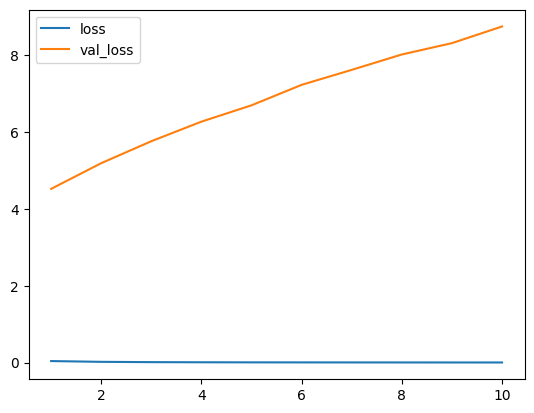

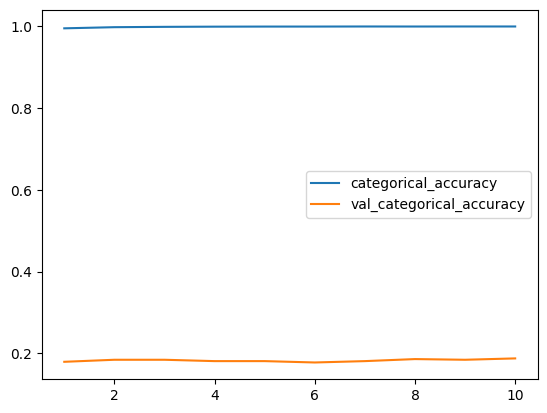

In [59]:
import pandas as pd

# Estatística do modelo
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}%")\
      .format(history_df['val_loss'].min(), 
              history_df['val_categorical_accuracy'].max()*100))

In [60]:
print(f"Acurácia em dados de teste: {round(model.evaluate(X_test, y_test)[1]*100, 4)}%")

29/29 [==============================] - 0s 950us/step - loss: 3.6784 - categorical_accuracy: 0.1772
Acurácia em dados de teste: 17.7187%


# Resultado Estratégia Extra:
    Acurácia em dados de teste: 17.7187%
    Best Validation Loss: 3.8329
    Best Validation Accuracy: 18.7708%